In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/t

In [2]:
data = pd.read_csv('data.csv')
data.head(7)

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname
0,47,239,1280,273,1280,418,38,377,1,img00.jpg
1,37,400,677,414,676,565,28,555,2,img00.jpg
2,37,561,673,573,672,718,33,711,3,img00.jpg
3,32,723,352,723,348,871,26,872,4,img00.jpg
4,359,724,671,728,667,876,356,873,5,img00.jpg
5,683,416,1280,428,1280,882,675,874,6,img00.jpg
6,353,109,3465,141,3489,481,345,481,1,img01.jpg


In [3]:
data['class'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [4]:
data[data.fname==data.fname.unique()[5]]

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,class,fname
30,66,32,1059,32,1061,151,63,150,1,img05.jpg
31,203,186,925,185,927,518,201,517,7,img05.jpg
32,225,297,904,297,902,400,226,400,8,img05.jpg
33,225,406,904,404,904,507,226,509,9,img05.jpg


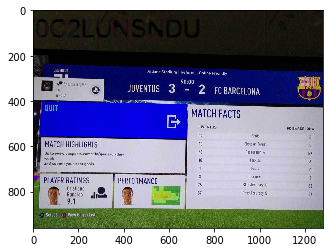

In [5]:
img = cv2.imread('data/img00.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
mask = np.zeros(img.shape)
mask.shape

(960, 1280, 3)

In [7]:
pts=np.array([[47,239],[1280,273],[1280,418],[38,377]])
mask = cv2.fillPoly(mask,[pts],color=(1,1,1))
#plt.imshow(mask)

In [8]:
data.fname.unique()

array(['img00.jpg', 'img01.jpg', 'img02.jpg', 'img03.jpg', 'img04.jpg',
       'img05.jpg', 'img06.jpg', 'img07.jpg', 'img08.jpg', 'img09.jpg',
       'img10.jpg', 'img11.jpg', 'img12.jpg', 'img13.jpg', 'img14.jpg',
       'img15.jpg', 'img16.jpg', 'img17.jpg', 'img18.jpg', 'img19.jpg'],
      dtype=object)

In [9]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    mask = np.zeros(img.shape)
    F = data[data.fname==f]
    for cl in F['class']:
        pts = F[data['class']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
        mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
    cv2.imwrite('annotations/'+f.split('.')[0]+'.png',mask)
        

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
ann = cv2.imread('annotations/img00.png')
#ann[239:240,47:48] #array([[[1, 1, 1]]], dtype=uint8)
#ann[416:417, 683:684] #array([[[6, 6, 6]]], dtype=uint8)

In [10]:
ann.shape

(960, 1280, 3)

In [11]:
r = cv2.resize(ann, (350,200))
r.shape

(200, 350, 3)

In [12]:
import imgaug as ia
import imgaug.augmenters as iaa

In [99]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    #iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [100]:
def augment_seg( img , seg ):
	
	aug_det = seq.to_deterministic() 
	image_aug = aug_det.augment_image( img )

	segmap = ia.SegmentationMapOnImage( seg , nb_classes=np.max(seg)+1 , shape=img.shape )
	segmap_aug = aug_det.augment_segmentation_maps( segmap )
	segmap_aug = segmap_aug.get_arr_int()

	return image_aug , segmap_aug

In [ ]:
# for f in data.fname.unique():
#     img = cv2.imread('data/'+f)
#     seg = cv2.imread('annotations/'+f.split('.')[0]+'.png')
#     augment_seg(img,seg)

In [108]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    seg = cv2.imread('annotations/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (480,360))
    seg_r = cv2.resize(seg, (480,360))
    cv2.imwrite('images_train/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('annotations_train/'+f.split('.')[0]+'.png',seg_r)

In [13]:
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.model_utils import transfer_weights

Using TensorFlow backend.
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/t

In [14]:
model = vgg_unet(n_classes=20 ,  input_height=416, input_width=608 )

Instructions for updating:
Colocations handled automatically by placer.


In [115]:
model.train(
    train_images =  "images_train/",
    train_annotations = "annotations_train/", epochs=5
)

100%|██████████| 20/20 [00:00<00:00, 194.54it/s]

Verifying training dataset
Dataset verified! 
Starting Epoch  0


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
512/512 [==============================] - 331s 646ms/step - loss: 1.1581 - accuracy: 0.6858
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
512/512 [==============================] - 307s 600ms/step - loss: 0.6104 - accuracy: 0.8139
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
512/512 [==============================] - 303s 592ms/step - loss: 0.3949 - accuracy: 0.8766
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
512/512 [==============================] - 304s 594ms/step - loss: 0.2211 - accuracy: 0.9307
Finished Epoch 3
Starting Epoch  4
Epoch 1/1
512/512 [==============================] - 306s 597ms/step - loss: 0.1434 - accuracy: 0.9600
Finished Epoch 4


In [18]:
#model.save('scr_segmentation.h5')
old_model = keras.models.load_model('scr_segmentation.h5')
transfer_weights( old_model , model)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0it [00:00, ?it/s]

Copying weights 


36it [00:11,  3.02it/s]

Copied weights of 19 layers and skipped 0 layers


## Imgae from train dataset

In [118]:
out = model.predict_segmentation(
    inp="images_train/img01.png",
    out_fname="out.png"
)

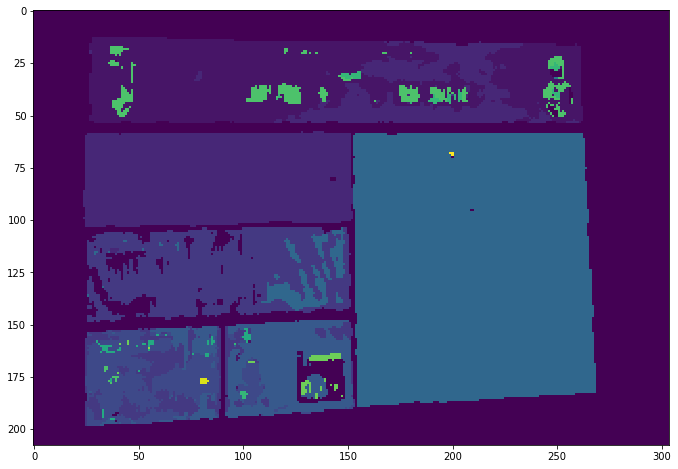

In [119]:
plt.figure(figsize=(12,8))
plt.imshow(out)

## Image that model didn't see before

In [19]:
#test image
img=cv2.imread('test.jpg')
img_r = cv2.resize(img, (480,360))
cv2.imwrite('test_resize.png',img_r)

True

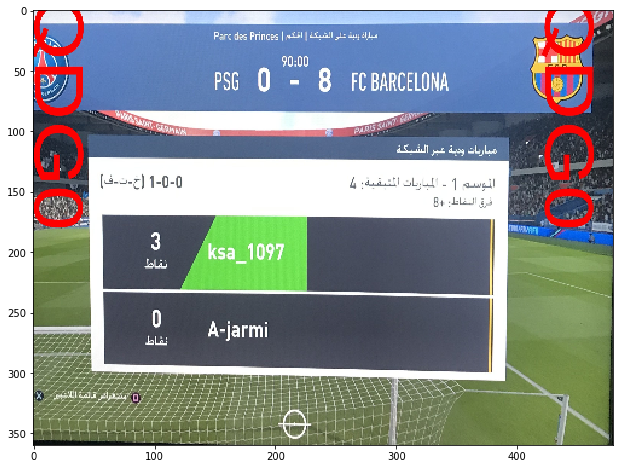

In [20]:
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

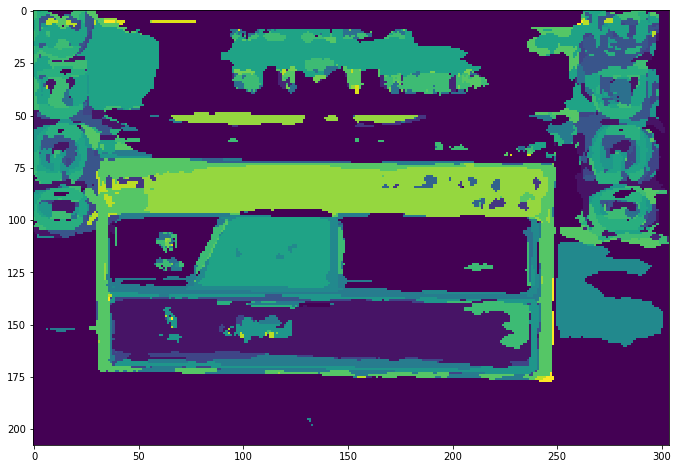

In [21]:
out = model.predict_segmentation(
    inp="test_resize.png",
    out_fname="out_test.png"
)
plt.figure(figsize=(12,8))
plt.imshow(out)

## Augmentation